In [1]:
from graph_class import *
from nltk_class import *
from text_mining import *
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')
sns.set_style('white')
update_parameter()

In [2]:
with open('noclean.json', 'r') as file:
    raw_tweet = pd.DataFrame(json.load(file))

dates_from, dates_to = '2021-08-26', '2021-09-08'
raw_tweet = raw_tweet.loc[(raw_tweet.created_at > dates_from) & (raw_tweet.created_at < dates_to)]

print(f'Whole Tweet: {len(raw_tweet)}, from {dates_from} to {dates_to}.')

Whole Tweet: 52684, from 2021-08-26 to 2021-09-08.


In [3]:
nlp = NltkTextProcessing()
tweet_unique = nlp.keep_unique(raw_tweet).reset_index(drop=True)
tweet_unique = nlp.process_df_text_column(tweet_unique, stem=False, min_len=3)
tweet_unique = nlp.process_df_hash_column(tweet_unique)

Tweets including retweets: 52684. Excluded: 13274


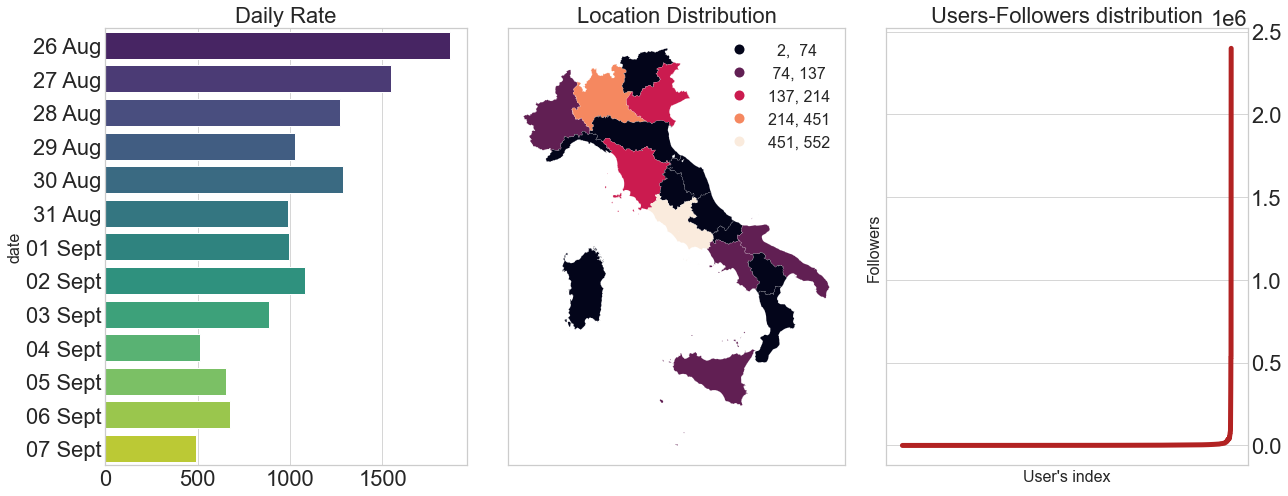

In [4]:
print(f"Tweets including retweets: {len(raw_tweet)}. Excluded: {len(tweet_unique)}")
nlp.plot_dates_location_followers(tweet_unique, save=True)

In [5]:
mining = TextMining()

just_text = tweet_unique.tweet_text.apply(lambda x: ' '.join(x).upper()) #upper
vectorized_text = mining.vectorized_text(just_text.values.tolist())
features_name = mining.get_features_names()

n_keywords = 2000
filtered_words = mining.extract_topn_from_vector(features_name, mining.sort_coo(vectorized_text), n_keywords)
filtered_words_set = set(map(str.upper, set(filtered_words)))

tokenized_keywords = nlp.take_only_keywords_from_tweets(just_text, filtered_words_set, min_len=2)

Shape of the Sparse Matrix (13274, 26846), type: <class 'scipy.sparse.csr.csr_matrix'>
Keywords founded: 1645
Remained docs: 4512


In [6]:
mining = TextMining() #with filtered tweets

vectorized_text = mining.vectorized_text([' '.join(x) for x in tokenized_keywords])
freq_distrib_tweet = nlp.frequency_dist(tokenized_keywords, obj='mine')

Shape of the Sparse Matrix (4512, 1151), type: <class 'scipy.sparse.csr.csr_matrix'>


In [7]:
min_occurencies = 10
main_word_graph =  NetworkPlot.graph_filtered_dist(tokenized_keywords, freq_distrib_tweet, min_occurencies, obj='mine') 

# degree_centrality = networkx.algorithms.centrality.degree_centrality(main_word_graph)
betweeneness_centrality = networkx.algorithms.centrality.betweenness_centrality(main_word_graph)
closeness_centrality = networkx.algorithms.centrality.closeness_centrality(main_word_graph)
centrality = [betweeneness_centrality, closeness_centrality]#, degree_centrality,]

print(f"Number of nodes: {len(main_word_graph)}")

Number of nodes: 324


In [ ]:
min_node_degree = 4
top_n_centrality_word = 100

graph_min_degree = NetworkPlot.keep_minimun_degree(main_word_graph, min_node_degree)
top_words_min = NetworkPlot.get_set_top_centrality_words(centrality, top=top_n_centrality_word)
NetworkPlot.keep_connected_components(graph_min_degree, min_degree = 10)

k = [3, 5, 7, 9, 10, 15, 20, 25, 30, 50, 65]
gamma = [0.5, 0.8, 1.0, 1.5, 2, 2.5, 3, 5, 10]
best_cluster_k = NetworkPlot.find_best_k_and_cluster(graph_min_degree, k=[2,4], gamma=[1.1])
best_cluster_k

Cluster distribution: [229, 41, 54], Silhouette Score: 0.2358202026568551


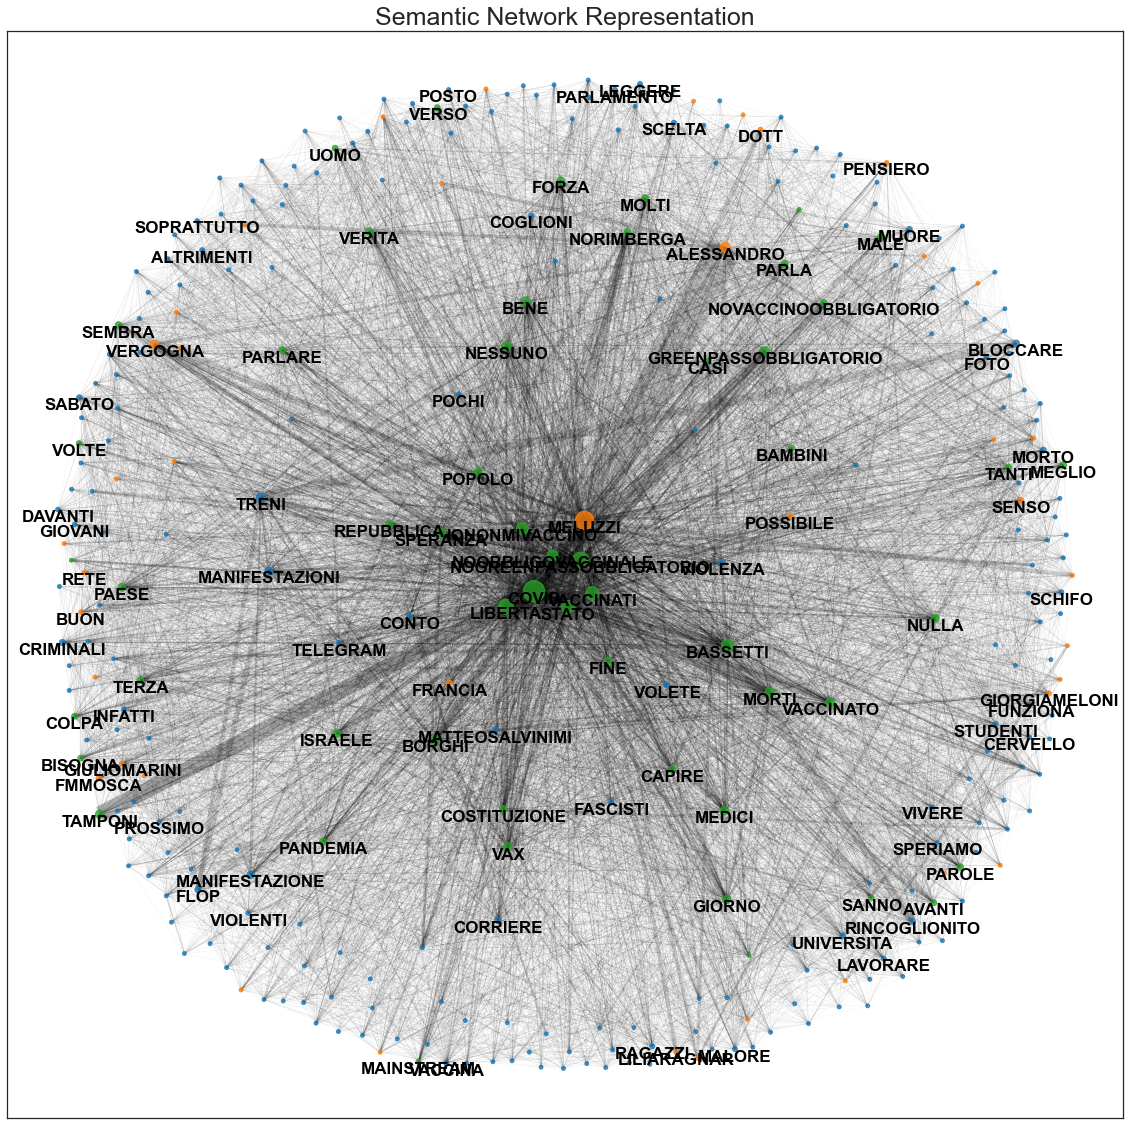

In [12]:
n_cluster, k, gamma = 3, 80, 3
cluster, cluster_label = NetworkPlot.spectral_clustering(graph_min_degree,n_cluster=n_cluster, w='count', k=10)
to_plot = NetworkPlot(graph_min_degree, freq_distrib_tweet, labels = cluster_label)

to_plot.plot_main_centrality(top_words_min, mul_factor=0.6, save='graphs', k=4, i=50, w='count')

In [ ]:
NetworkPlot.plot_centrality_v(centrality, save=True, h=10, names = "Degree Betwenness,Degree Closeness", lb=11)

In [ ]:
top_n = 15
NetworkPlot.count_barplot(nlp.extract_external_url(raw_tweet), to=top_n, save=True)

In [ ]:
topics, top_word = 4, 10
lda_model = mining.lda_topic_modeling(vectorized_text, topics) # count_vector?
mining.plot_lda_topic(lda_model, topics, n_top_words=top_word, save=True)

In [ ]:
bag_of_words = mining.word_cloud_dict(lda_model)
mining.plot_wordcloud(bag_of_words, n_topics=4, save='lda-topics')

In [ ]:
k = 5
sparse_mat = networkx.to_numpy_matrix(graph_min_degree, weight ='count')
umap_reduced = pd.DataFrame(mining.umaps(sparse_mat, k=k), columns=[f'Component {i + 1}' for i in range(2)]) 
umap_reduced['labels'] = list(graph_min_degree.nodes())

mining.plot_umaps(umap_reduced, n_cluster=n_cluster, k=k, palette='tab10', save='umap')

plot_main_centrality(graph_min_degree, top_words_min, mul_factor=0.6, save='graphs', k=6, i=50, w='count')

def plot_main_centrality(graph, res, mul_factor: int = 5, save: str = None, upper=True, k=2, i=50, w='count'):
    fig, axes= plt.subplots(1,1, figsize=(20, 20))
    plt.style.use('seaborn-white')
    layout=networkx.spring_layout(graph, k=k, iterations=i, weight=w)


    networkx.draw_networkx_nodes(G=graph,
                              pos=layout,
                              cmap=plt.get_cmap('autumn'),
                              ax=axes,
                              alpha=0.8)

    networkx.draw_networkx_edges(G=graph,
                                 pos=layout,
                                 width = [graph[u][v]['count'] / 10 for u,v in graph.edges],
                                 alpha=0.15)

    networkx.draw_networkx_labels(graph,
                                  pos=layout,
                                  font_size=17,
                                  ax=axes,
                                  font_color='black',
                                  font_weight='bold',
                                  verticalalignment='top')
    axes.set_axis_on()
    axes.grid(False)
    plt.title('Semantic Network Representation', fontsize=25)